In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import panel as pn
import itertools
import math
import param
import fsspec

pn.extension()

In [2]:
image_bucket = "ncar-cesm-pop-test/images"
fs = fsspec.filesystem("s3", anon=True)

In [3]:
files = fs.glob(f"{image_bucket}/*/*.png")
len(files)

2338

In [4]:
# image_dir = Path("./images")
# files = list(image_dir.rglob("*/*.png"))
# len(files)

In [5]:
def parse_file(file):
    path = file
    file = Path(file)
    x = dict(path=path)
    if "checkpoint" in path:
        return {}
    plot_type = file.parent.stem
    x["plot_type"] = plot_type
    parts = file.stem.split("+")
    x["varname"] = parts[0]
    if plot_type == "timestep-global-map":
        x["plot_type"] = plot_type
        x["time"] = parts[1]
    if len(parts) > 2:
        if plot_type == "global-timeseries":
            idx = 1
        else:
            idx = 2
        for part in parts[idx:]:
            y = part.split("@")
            x[y[0]] = y[1]
            if y[0].startswith("z_t"):
                x["depth_level"] = y[1]
    return x


entries = [parse_file(file) for file in files]

In [6]:
df = pd.DataFrame(entries).dropna(subset=["path"])

df["z_t"] = df["z_t"].astype(float)
df["z_t_150m"] = df["z_t_150m"].astype(float)
df["depth_level"] = df["depth_level"].astype(float)
df["depth_level"] = df["depth_level"].fillna(-9999)
df["log_10"] = df.log_10.map(lambda x: True if x == "True" else False)

grouped = df.groupby(["varname", "time", "depth_level", "log_10"])
df.head()

path          plot_type  \
0  ncar-cesm-pop-test/images/global-timeseries/Ca...  global-timeseries   
1  ncar-cesm-pop-test/images/global-timeseries/Dp...  global-timeseries   
2  ncar-cesm-pop-test/images/global-timeseries/FG...  global-timeseries   
3  ncar-cesm-pop-test/images/global-timeseries/NH...  global-timeseries   
4  ncar-cesm-pop-test/images/global-timeseries/NH...  global-timeseries   

            varname spatial_op time_coarsen_len    z_t  depth_level  z_t_150m  \
0   CaCO3_FLUX_100m  integrate               12    NaN      -9999.0       NaN   
1             DpCO2    average               12    NaN      -9999.0       NaN   
2            FG_CO2  integrate               12    NaN      -9999.0       NaN   
3               NH4    average               12  500.0        500.0       NaN   
4  NHx_SURFACE_EMIS  integrate               12    NaN      -9999.0       NaN   

  time  log_10  
0  NaN   False  
1  NaN   False  
2  NaN   False  
3  NaN   False  
4  NaN   False

In [7]:
groups = {}
grouped = df.groupby("plot_type")
for key in grouped.groups:
    groups[key] = grouped.get_group(key)
groups.keys()

dict_keys(['global-timeseries', 'timestep-global-map'])

In [8]:
class BaseDashboard(param.Parameterized):
    variable = param.ObjectSelector(
        default="CaCO3_FLUX_100m", objects=sorted(df.varname.unique().tolist())
    )
    depth_level = param.ObjectSelector(
        default=-9999, objects=sorted(df.depth_level.unique().tolist())
    )

    def get_data(self):
        raise NotImplementedError()

    def plot(self):
        nrows, ncols = 1, 1
        fig, ax = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(8, 6), squeeze=True
        )
        try:
            df = self.get_data()
            path = df.iloc[0].path
            with fs.open(path) as f:
                data = img.imread(f)
            ax.imshow(data)

        except KeyError:
            pass

        ax.axis("off")
        plt.tight_layout()
        plt.close(fig)
        return fig


class TimestepDashboard(BaseDashboard):
    _df = groups["timestep-global-map"]
    apply_log10 = param.Boolean(default=False)
    time = param.Selector(objects=sorted(_df.time.unique().tolist()))
    grouped = _df.groupby(["varname", "time", "depth_level", "log_10"])

    def get_data(self):
        key = self.variable, self.time, self.depth_level, self.apply_log10
        df = self.grouped.get_group(key)
        return df


dd_left = TimestepDashboard(name="")
dd_right = TimestepDashboard(name="", variable="O2_ZMIN_DEPTH")
one_timestep_dashboard = pn.Column(
    "# Time Slice Global Map",
    pn.Row(
        pn.Column(pn.Row(dd_left.param), pn.Row(dd_left.plot)),
        pn.Column(pn.Row(dd_right.param), pn.Row(dd_right.plot)),
        sizing_mode="stretch_both",
    ),
)

In [9]:
class TimeseriesDashboard(BaseDashboard):
    _df = groups["global-timeseries"]
    spatial_operation = param.Selector(
        objects=sorted(_df.spatial_op.unique().tolist())
    )
    time_coarsen_length = param.Selector(
        objects=sorted(_df.time_coarsen_len.unique().tolist())
    )
    grouped = _df.groupby(
        ["varname", "spatial_op", "time_coarsen_len", "depth_level"]
    )

    def get_data(self):
        key = (
            self.variable,
            self.spatial_operation,
            self.time_coarsen_length,
            self.depth_level,
        )
        df = self.grouped.get_group(key)
        return df


td_left = TimeseriesDashboard(name="", variable="O2_ZMIN")
td_right = TimeseriesDashboard(name="", variable="O2_ZMIN_DEPTH")
timeseries_dashboard = pn.Column(
    "# Timeseries Plot",
    pn.Row(
        pn.Column(pn.Row(td_left.param), pn.Row(td_left.plot)),
        pn.Column(pn.Row(td_right.param), pn.Row(td_right.plot)),
        sizing_mode="stretch_both",
    ),
)

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row(sizing_mode='stretch_both')
            [0] Column
                [0] Row
                    [0] Column(margin=5, width=300)
                        [0] StaticText(value='<b></b>')
                        [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='CaCO3_FLUX_100m')
                        [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999)
                        [3] Checkbox(name='Apply log10')
                        [4] Select(name='Time', options=OrderedDict([('0001-01-16 ...]), value='0001-01-16 12:15:50')
                [1] Row
                    [0] ParamMethod(method)
            [1] Column
                [0] Row
                    [0] Column(margin=5, width=300)
                        [0] StaticText(value='<b></b>')
                        [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN_DEPTH')
                        [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999)
                        [3] Checkbox(name='Apply log10')
                        [4] Select(name='Time', options=OrderedDict([('0001-01-16 ...]), value='0001-01-16 12:15:50')
                [1] Row
                    [0] ParamMethod(method)
    [1] Column
        [0] Markdown(str)
        [1] Row(sizing_mode='stretch_both')
            [0] Column
                [0] Row
                    [0] Column(margin=5, width=300)
                        [0] StaticText(value='<b></b>')
                        [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN')
                        [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999)
                        [3] Select(name='Spatial operation', options=OrderedDict([('average', ...]), value='average')
                        [4] Select(name='Time coarsen length', options=OrderedDict([('12', ...]), value='12')
                [1] Row
                    [0] ParamMethod(method)
            [1] Column
                [0] Row
                    [0] Column(margin=5, width=300)
                        [0] StaticText(value='<b></b>')
                        [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN_DEPTH')
                        [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999)
                        [3] Select(name='Spatial operation', options=OrderedDict([('average', ...]), value='average')
                        [4] Select(name='Time coarsen length', options=OrderedDict([('12', ...]), value='12')
                [1] Row
                    [0] ParamMethod(method)
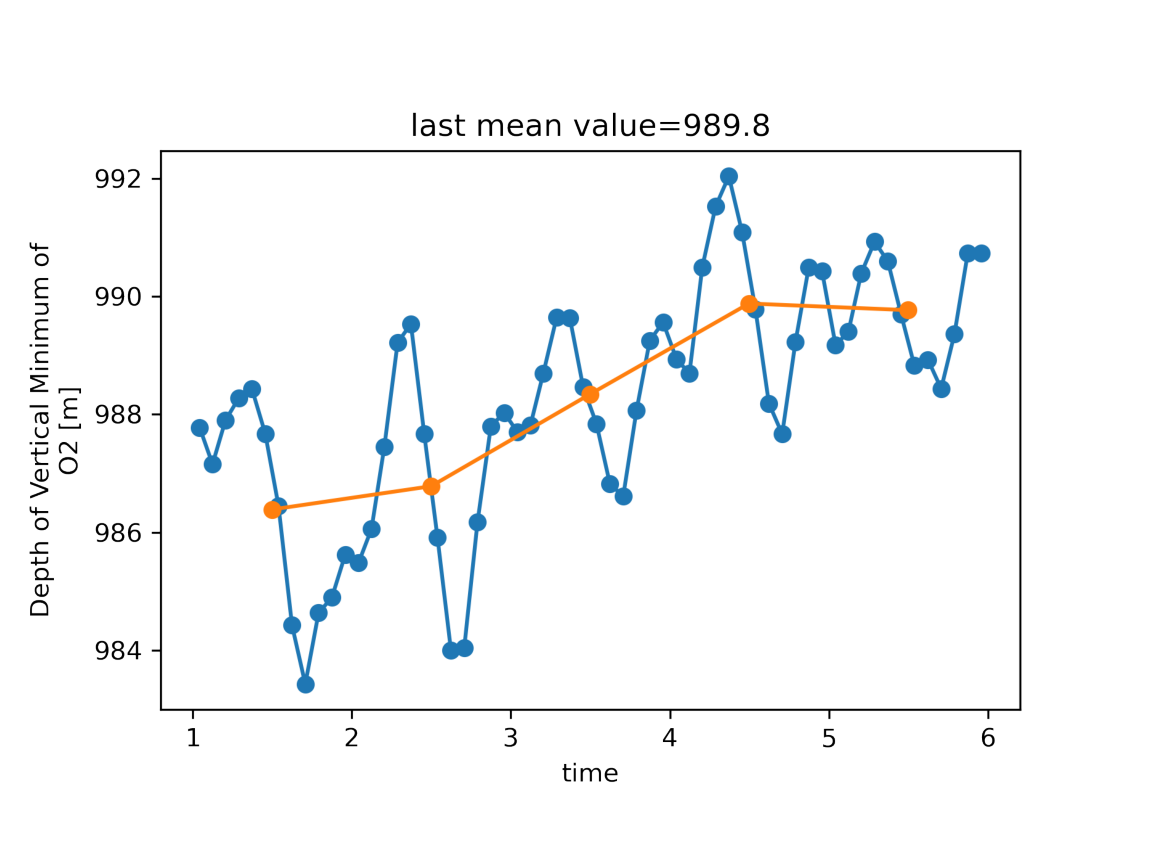
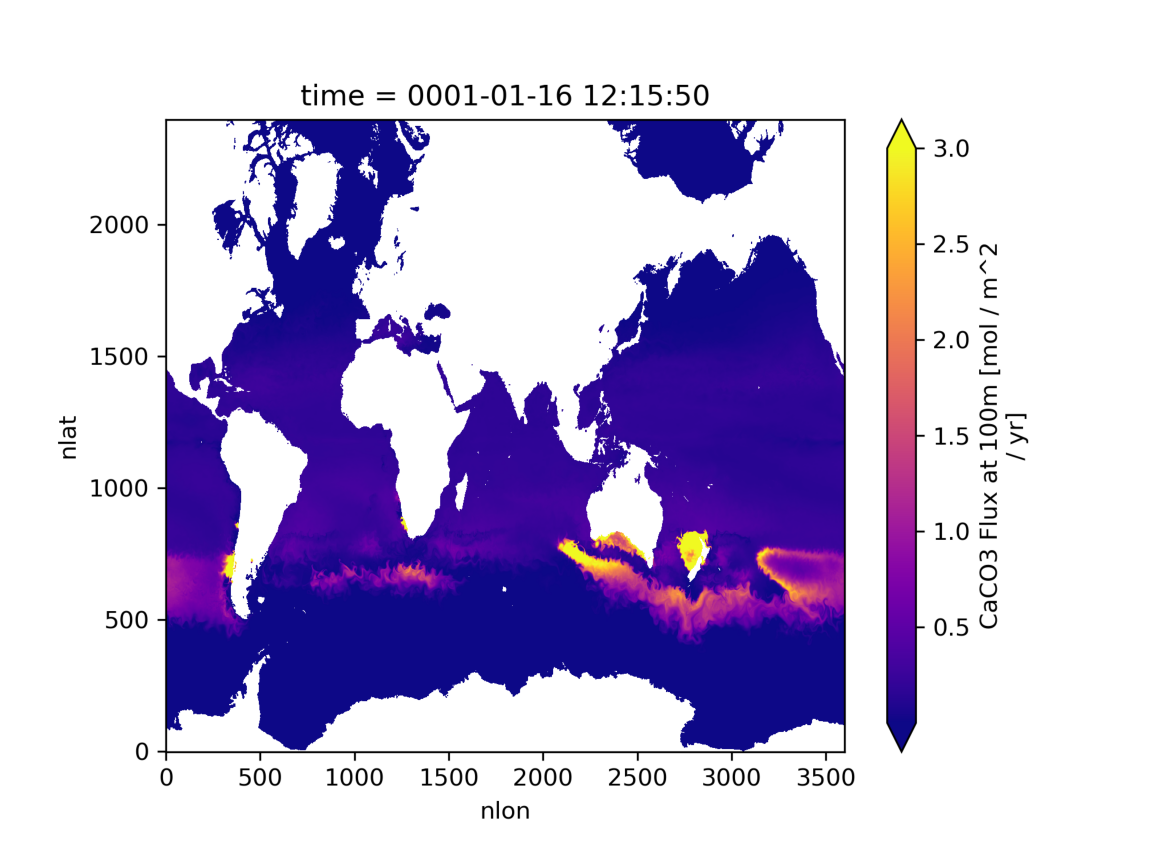
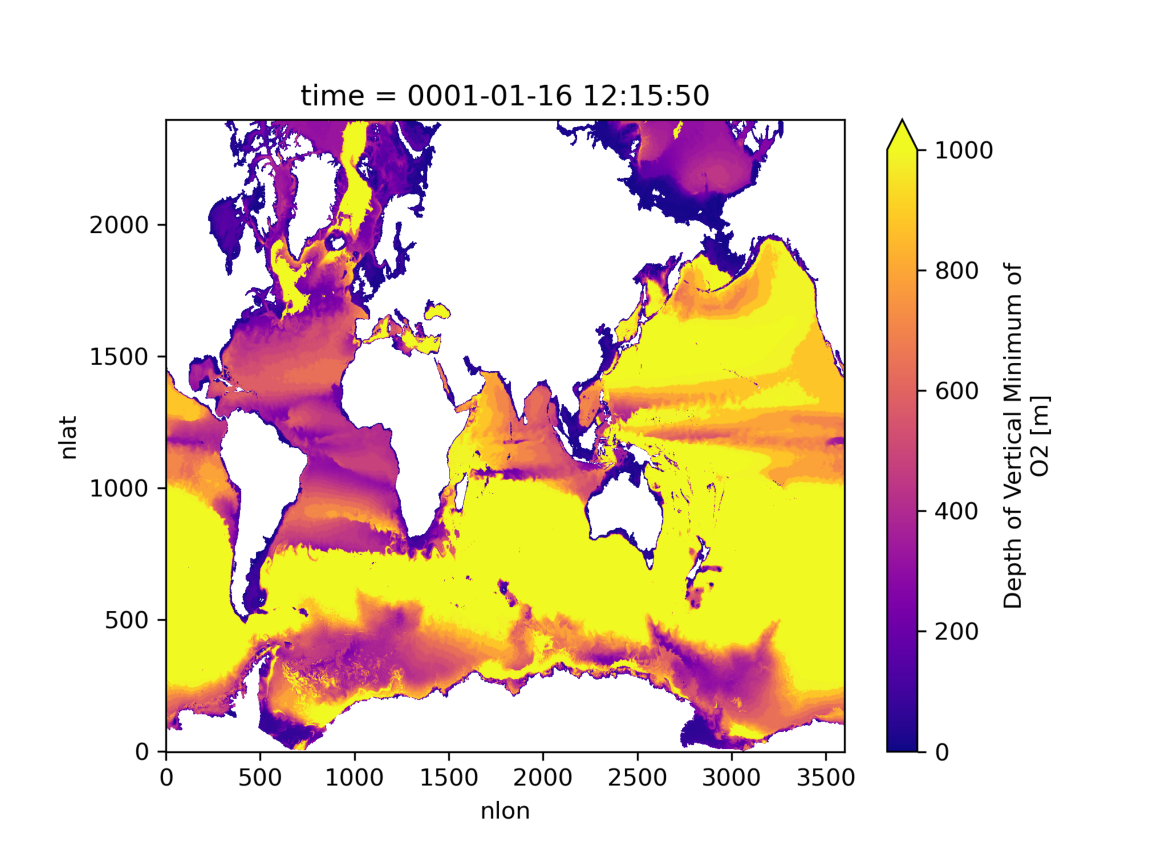
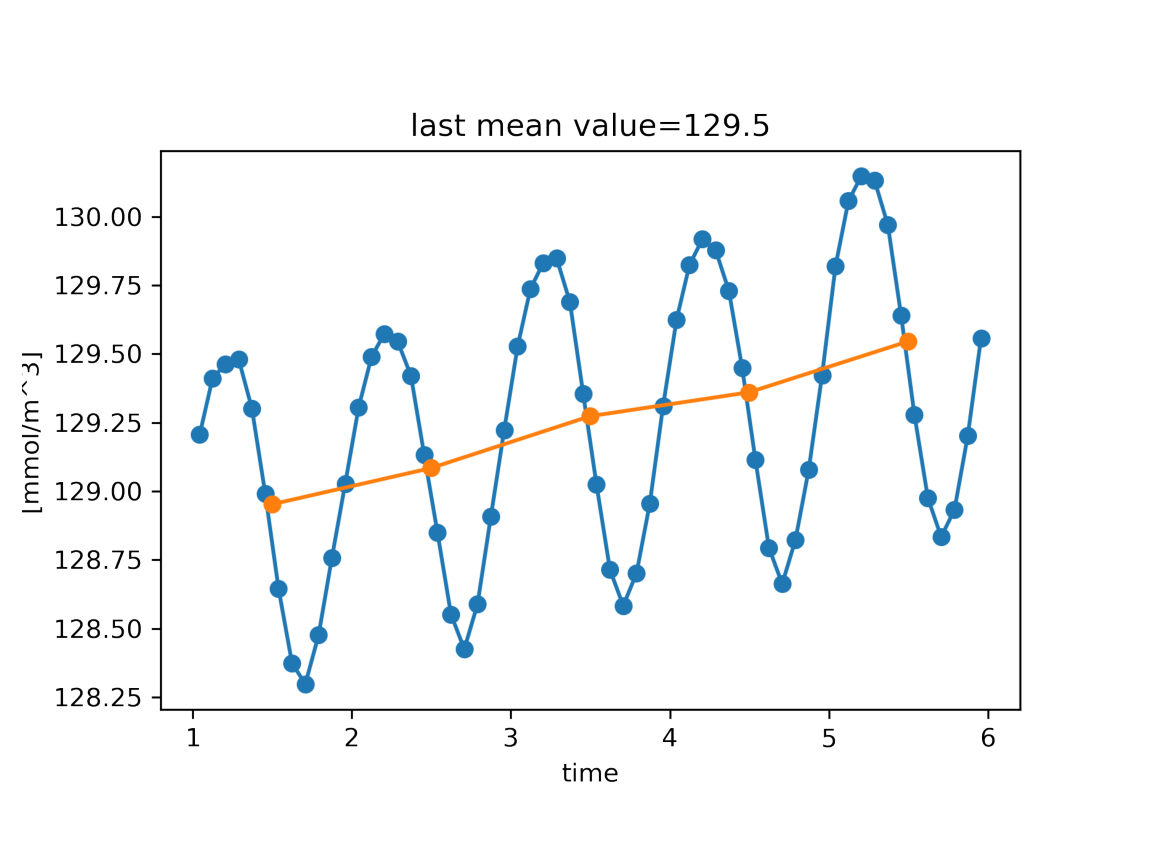

In [10]:
dashboard = pn.Tabs(
    ("Time Slice Global Maps", one_timestep_dashboard),
    ("Timeseries Plots", timeseries_dashboard),
)
dashboard.servable("HiRes-CESM Diagnostics Dashboard")